#  Прогнозирование заказов такси

**Данные**

В наличии исторические данные о заказах такси в аэропортах. 

* Дата-время
* Количество заказов

**Задача**

Спрогнозировать количество заказов такси на следующий час.  
Построить модель для такого предсказания.  
Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Необходимо:**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

## Подготовка

In [276]:
data = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])

data.head(6)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21


In [277]:
data.index.is_monotonic

True

In [278]:
# Ресемплирование по одному часу

data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [279]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


---
Пропусков нет.

## Анализ

In [280]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Раскладываю на составляющие и вывожу графики

**Тренд**

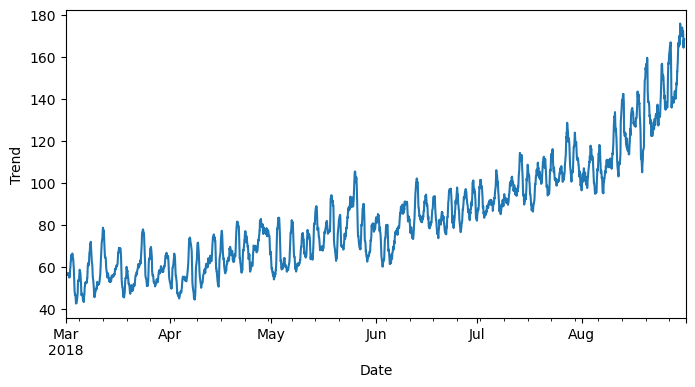

In [281]:
decompose_daily = seasonal_decompose(data)
decompose_daily.trend.plot(figsize=(8,4))
plt.xlabel('Date'), plt.ylabel('Trend');

Виден тренд на увеличение числа заказов.  

**Сезонность суточная**

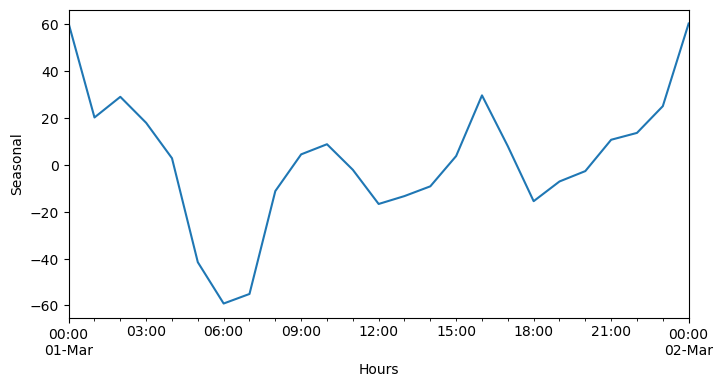

In [282]:
ax = decompose_daily.seasonal['2018-03-01-00':'2018-03-02-00'].plot(figsize=(8,4))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=24))
plt.xlabel('Hours'), plt.ylabel('Seasonal');

**Сезонность недельная**

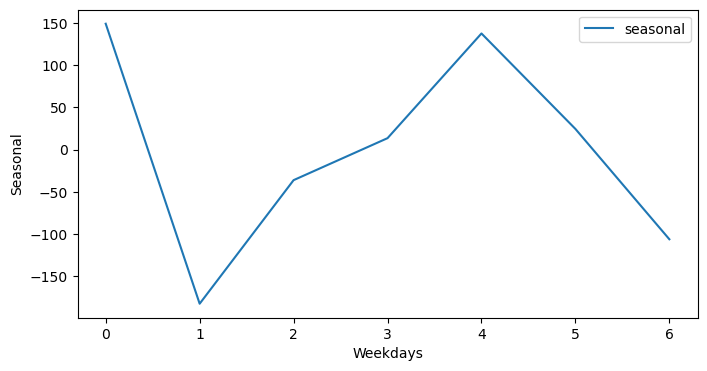

In [283]:
decompose_weekly = seasonal_decompose(data.resample('1D').sum())
df = pd.DataFrame(decompose_weekly.seasonal['2018-03-05-00':'2018-03-11-00'])
df.index = df.index.weekday
df.plot(figsize=(8,4))
plt.xlabel('Weekdays'), plt.ylabel('Seasonal');

* Сезонность суточная
    * Падение числа заказов около 6 часов утра;
    * Увеличение числа заказов в районе 9 часов утра и 4 часов вечера
    * Макимум заказов в полночь
* Сезонность недельная
    * Максимиум заказов в Понедельник и Пятницу
    * Минимум - Вторник, Воскресенье

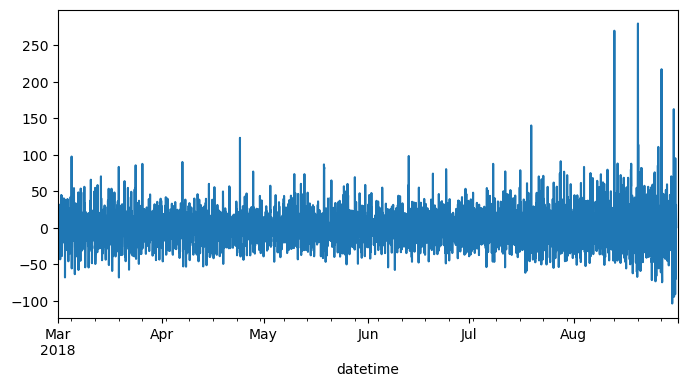

In [284]:
ax = decompose_daily.resid.plot(figsize=(8,4))

Некоторое увеличение шума к концу рассматриваемого периода.  
Т.е. в данных тестовой выборки будет больше шума. 

**Анализ значимости лагов с помощью автокорреляции**

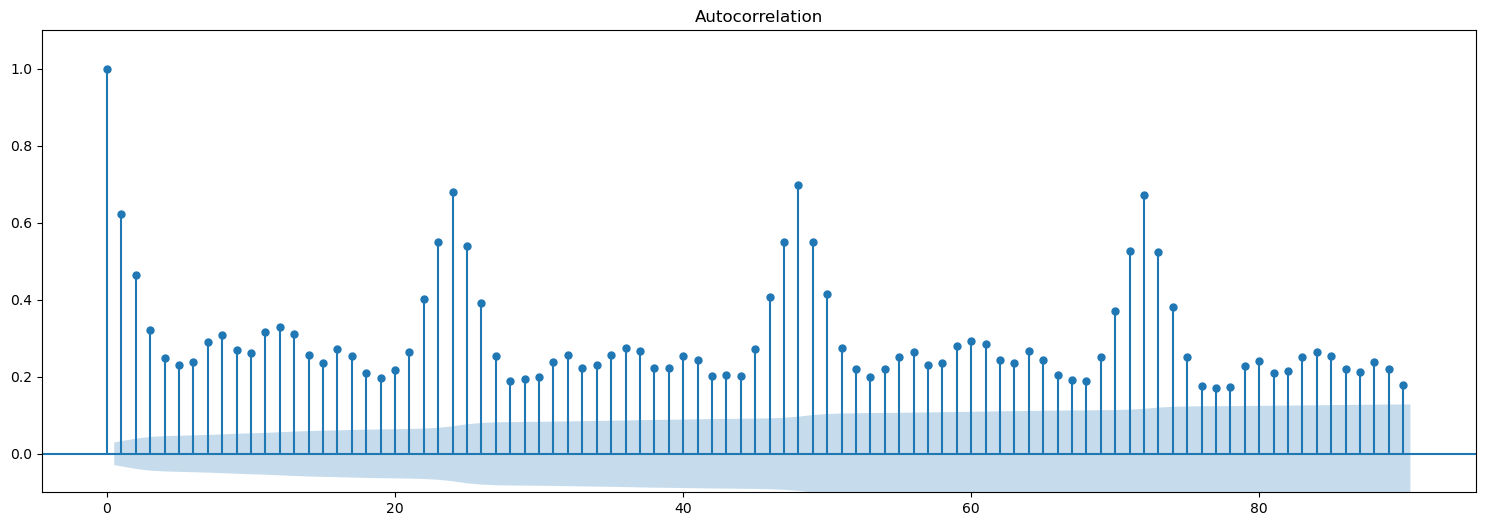

In [285]:
# Код ревьюера
from statsmodels.graphics import tsaplots

fig = tsaplots.plot_acf(data['num_orders'],lags= 90)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1);

По результатам анализа, буду создавать следующие признаки:
* день месяца;
* день недели;
* время, час;
* лаг с разницей в 1 час;
* лаг с разницей 24 часа;
* лаг с разницей 25 часов;
* лаг с разницей в неделю
* лаг с разницей в неделю и 1 час
* скользящее среднее за 4 часа

## Обучение

### Создание признаков

Создаю признаки в соответствии со списком выше

In [286]:
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour

for lag in [1, 24, 25, 168, 169]:
    data['lag_'+str(lag)] = data.num_orders.shift(lag)

data['roll_mean'] = data.num_orders.shift().rolling(4).mean()

In [287]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   num_orders  4416 non-null   int64  
 1   day         4416 non-null   int64  
 2   dayofweek   4416 non-null   int64  
 3   hour        4416 non-null   int64  
 4   lag_1       4415 non-null   float64
 5   lag_24      4392 non-null   float64
 6   lag_25      4391 non-null   float64
 7   lag_168     4248 non-null   float64
 8   lag_169     4247 non-null   float64
 9   roll_mean   4412 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 379.5 KB


### Деление на выборки

In [289]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

In [290]:
# Обучающую делю на обучающую и валидационную

train_1, valid = train_test_split(train, shuffle=False, test_size=0.1)
train_1 = train_1.dropna()
X_train = train_1.drop('num_orders', axis=1)
y_train = train_1.num_orders
X_valid = valid.drop('num_orders', axis=1)
y_valid = valid.num_orders

### LinearRegression

Использую валидационную выборку = 10% от train

In [292]:
%%time
    
model = LinearRegression()
model.fit(X_train, y_train)

Wall time: 7.73 ms


LinearRegression()

In [293]:
%%time

mean_squared_error(y_valid, model.predict(X_valid))**0.5

Wall time: 6.27 ms


30.89454745248007

### LGBMRegressor

Использую параметры модели по умолчанию и валидационную выборку = 10% от train

In [299]:
%%time

model = LGBMRegressor(random_state=123)
model.fit(X_train, y_train)
mean_squared_error(y_valid, model.predict(X_valid))**0.5

Wall time: 108 ms


32.20335760830537

**Подбор параметров модели**

In [303]:
best_rmse = 999
for depth in range(2,8):
    for rate in np.arange(0.1, 1, 0.1):
        for estim in range(90, 130, 10):
            model = LGBMRegressor(max_depth= depth, learning_rate= rate,
                                  n_estimators=estim, random_state=123)
            model.fit(X_train, y_train)
            rmse = mean_squared_error(y_valid, model.predict(X_valid))**0.5
            if rmse < best_rmse:
                best_rmse = rmse
                best_depth = depth
                best_rate = rate
                best_estim = estim
                LGBM_best = model
best_rmse, best_depth, best_rate, best_estim

(30.786807583449214, 2, 0.2, 110)

In [304]:
%%time
    
model = LGBMRegressor(max_depth= best_depth, learning_rate= best_rate,
                      n_estimators=best_estim, random_state=123)
model.fit(X_train, y_train)

Wall time: 25.3 ms


LGBMRegressor(learning_rate=0.2, max_depth=2, n_estimators=110,
              random_state=123)

In [305]:
%%time

mean_squared_error(y_valid, LGBM_best.predict(X_valid))**0.5

Wall time: 6.21 ms


30.786807583449214

## Тестирование

RMSE на валидационной выборке:
* LinearRegression - 30.9
* LGBMRegressor - 30.8

Время обучения / предсказания
* LinearRegression - 8 / 6 ms
* LGBMRegressor - 25 / 6 ms


Для тестирования буду использовать LinearRegression


In [307]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

train = train.dropna()
X_train = train.drop('num_orders', axis=1)
y_train = train.num_orders
X_test = test.drop('num_orders', axis=1)
y_test = test.num_orders

In [308]:
model = LinearRegression()
model.fit(X_train, y_train)
mean_squared_error(y_test, model.predict(X_test))**0.5

36.256437740710005

Результат < 48  
Цель достигнута.

### Проверка на адекватность

**Dummy со средним значением**

In [309]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
mean_squared_error(y_test, dummy.predict(X_test))**0.5

83.99140594943991

**Dummy с предыдущим значением**

In [310]:
y_pred_previous = y_test.shift()
y_pred_previous[0] = y_train[-1]
mean_squared_error(y_test, y_pred_previous)**0.5

58.856486242815066

**Заключение:**  
* LinearRegression показала сравнимое качество, что и LGBM при значительно меньшем времени обучения и предсказания.  
* LinearRegression оказалась значительно лучше Dummy_previous value (RMSE 36 vs 59).

